In [2]:
import pandas as pd
import os
import re
import json
import yaml
from glob import glob
from tqdm import tqdm
from pprint import pprint
import torch
import pytorch_lightning as pl
from rouge import Rouge # Î™®Îç∏Ïùò ÏÑ±Îä•ÏùÑ ÌèâÍ∞ÄÌïòÍ∏∞ ÏúÑÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨ÏûÖÎãàÎã§.

from torch.utils.data import Dataset , DataLoader
from transformers import AutoTokenizer, BartForConditionalGeneration, BartConfig
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback

import wandb # Î™®Îç∏ ÌïôÏäµ Í≥ºÏ†ïÏùÑ ÏÜêÏâΩÍ≤å TrackingÌïòÍ≥†, ÏãúÍ∞ÅÌôîÌï† Ïàò ÏûàÎäî ÎùºÏù¥Î∏åÎü¨Î¶¨ÏûÖÎãàÎã§.

# Î≤°ÌÑ∞ ÏûÑÎ≤†Îî© Î∂ÑÏÑù

In [3]:
data_path = "../../data/"

train_df = pd.read_csv(os.path.join(data_path, "train_eda.csv"))

In [4]:
bins = [0.0, 0.3, 0.6, 1.0]
labels = ['low', 'mid', 'high']
train_df['coverage_bin'] = pd.cut(train_df['coverage_ratio'], bins=bins, labels=labels)

In [5]:

with open("../../config/config.yaml", "r") as f:
    config = yaml.safe_load(f)

print(config["tokenizer"]["special_tokens"])

['#Address#', '#Alex#', '#Bob#', '#CardNumber#', '#CarNumber#', '#DateOfBirth#', '#Email#', '#Kristin#', '#Liliana#', '#Name#', '#PassportNumber#', '#Person1#', '#Person2#', '#Person3#', '#Person4#', '#Person5#', '#Person6#', '#Person7#', '#PersonName#', '#PhoneNumber#', '#Price#', '#SSN#']


In [6]:
from transformers import BartTokenizer, BartModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

special_tokens_dict = {
  "additional_special_tokens": config["tokenizer"]["special_tokens"]
}

tokenizer.add_special_tokens(special_tokens_dict)

model = BartModel.from_pretrained("facebook/bart-base")
model.resize_token_embeddings(len(tokenizer))
model.to(device)
model.eval()


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BartModel(
  (shared): Embedding(50287, 768)
  (encoder): BartEncoder(
    (embed_tokens): Embedding(50287, 768)
    (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
    (layers): ModuleList(
      (0-5): 6 x BartEncoderLayer(
        (self_attn): BartAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=True)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
    )
    (layernorm_embedding): LayerNorm((768,), eps=1e-05, ele

In [ ]:
def get_bart_embeddings_batch(texts, batch_size=32):
    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            embeddings = outputs.last_hidden_state.mean(dim=1)  # [B, H]
            all_embeddings.extend(embeddings.cpu())  # Í∞úÎ≥Ñ tensor Ï†ÄÏû•
    return all_embeddings # [CLS] Ïú†ÏÇ¨ mean pooling

In [8]:
def get_bin_embeddings(bin, df):
    df_bin = df[df["coverage_bin"] == bin]
    texts = df_bin["dialogue"].tolist()
    embeddings = get_bart_embeddings_batch(texts, batch_size=32)
    return embeddings

In [9]:
high_embeddings = get_bin_embeddings("high", train_df)
mid_embeddings = get_bin_embeddings("mid", train_df)
low_embeddings = get_bin_embeddings("low", train_df)

Embedding batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [00:00<00:00,  3.50it/s]


In [28]:
import umap.umap_ as umap
import hdbscan

def plot_dbscan_clusters(embeddings, title, min_cluster_size=30):
  X = np.stack([emb.numpy() if hasattr(emb, "numpy") else emb for emb in embeddings])

  # 1. UMAP Ï∞®Ïõê Ï∂ïÏÜå
  X_umap = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42).fit_transform(X)

  X_umap = (X_umap - X_umap.min(0)) / (X_umap.max(0) - X_umap.min(0))

  # 2. HDBSCAN ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ
  clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size).fit(X_umap)
  labels = clusterer.labels_  # -1: ÎÖ∏Ïù¥Ï¶à

  # 3. ÏãúÍ∞ÅÌôî
  import matplotlib.pyplot as plt
  plt.figure(figsize=(8,6))
  plt.scatter(X_umap[:,0], X_umap[:,1], c=labels, cmap='Spectral', s=10)
  plt.title(f"{title} UMAP + HDBSCAN Clustering")
  plt.colorbar()
  plt.show()

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


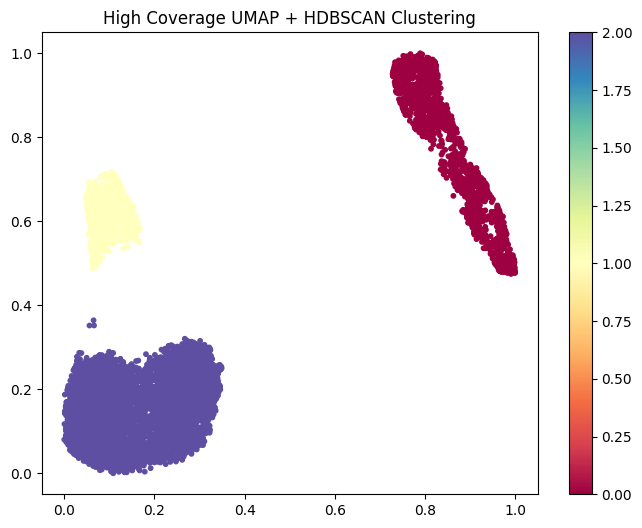

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


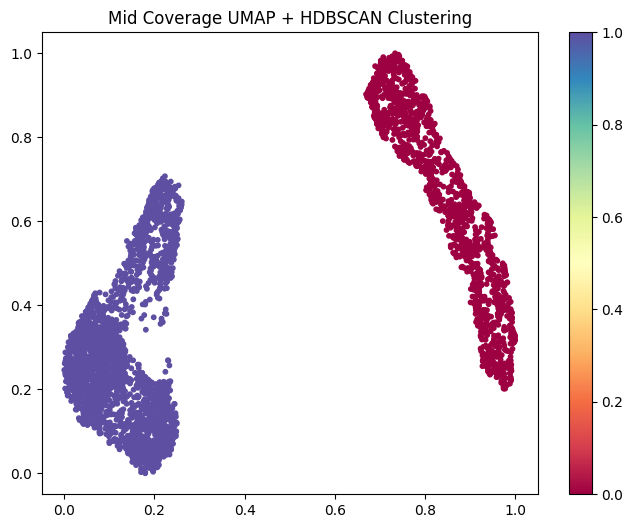

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


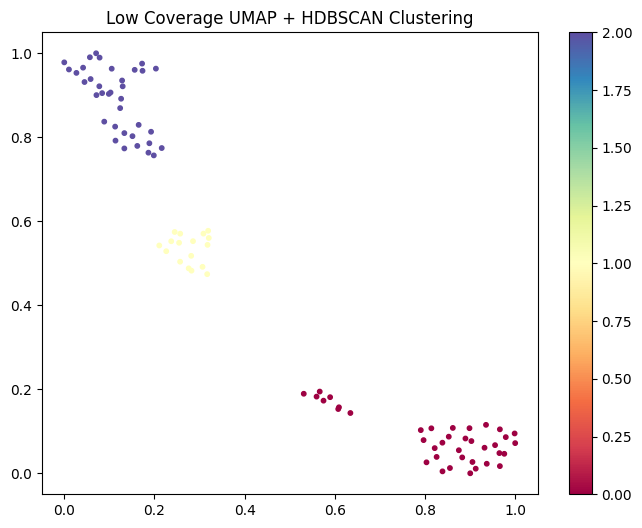

In [30]:
plot_dbscan_clusters(high_embeddings, "High Coverage")
plot_dbscan_clusters(mid_embeddings, "Mid Coverage")
plot_dbscan_clusters(low_embeddings, "Low Coverage", 10)

In [25]:
def get_bin_embeddings_summary(bin, df):
    df_bin = df[df["coverage_bin"] == bin]
    texts = df_bin["summary"].tolist()
    embeddings = get_bart_embeddings_batch(texts, batch_size=32)
    return embeddings

In [ ]:
high_embeddings_summary = get_bin_embeddings_summary("high", train_df)
mid_embeddings_summary = get_bin_embeddings_summary("mid", train_df)
low_embeddings_summary = get_bin_embeddings_summary("low", train_df)

Embedding batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [00:00<00:00, 10.39it/s]


/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


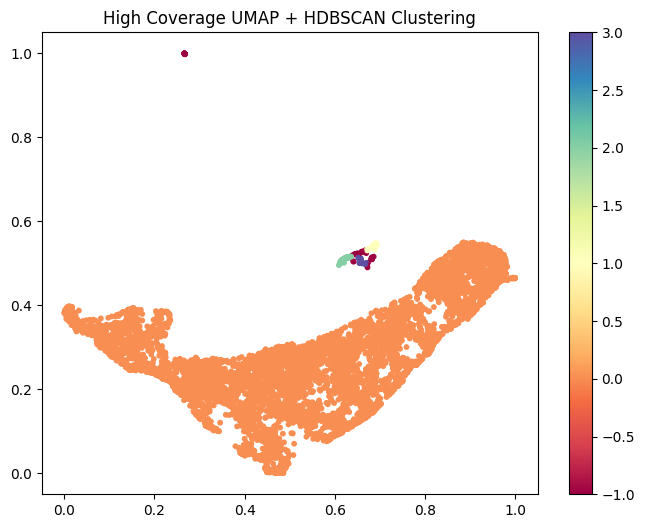

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


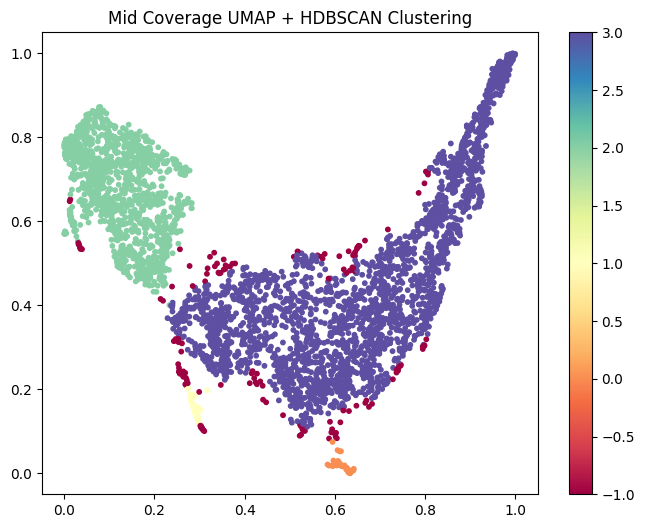

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


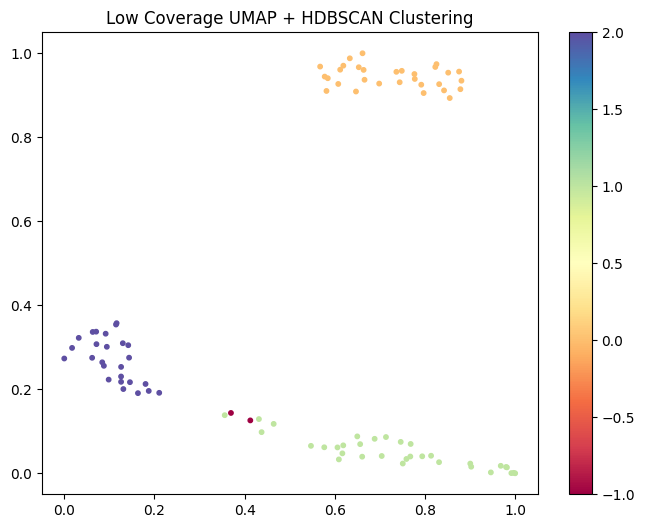

In [32]:
plot_dbscan_clusters(high_embeddings_summary, "High Coverage")
plot_dbscan_clusters(mid_embeddings_summary, "Mid Coverage")
plot_dbscan_clusters(low_embeddings_summary, "Low Coverage", 10)

## HIGH Í∑∏Î£π ÏõêÎ¨∏ ÏöîÏïΩÎ¨∏ ÌôïÏù∏

In [33]:
n = 15
print(f"-----------------------------------{n}Í∞ú Îç∞Ïù¥ÌÑ∞-----------------------------------")
for i in range(n):
  print(f"ÏõêÎ¨∏[{i}] {train_df[train_df['coverage_bin'] == 'high'].iloc[i]['dialogue']}")
  print(f"ÏöîÏïΩÎ¨∏[{i}] {train_df[train_df['coverage_bin'] == 'high'].iloc[i]['summary']}")
  print(f"Ïª§Î≤ÑÎ¶¨ÏßÄ ÎπÑÏú®[{i}] {train_df[train_df['coverage_bin'] == 'high'].iloc[i]['coverage_ratio']}")
  print(f"ÎπÑÏª§Î≤ÑÎ¶¨ÏßÄ ÎπÑÏú®[{i}] {train_df[train_df['coverage_bin'] == 'high'].iloc[i]['noncoverage_ratio']}")
  print("-"*100)

-----------------------------------15Í∞ú Îç∞Ïù¥ÌÑ∞-----------------------------------
ÏõêÎ¨∏[0] #Person1#: ÏïàÎÖïÌïòÏÑ∏Ïöî, Mr. Smith. Ï†ÄÎäî Dr. HawkinsÏûÖÎãàÎã§. Ïò§Îäò Î¨¥Ïä® ÏùºÎ°ú Ïò§ÏÖ®Ïñ¥Ïöî? 
#Person2#: Í±¥Í∞ïÍ≤ÄÏßÑÏùÑ Î∞õÏúºÎ†§Í≥† ÏôîÏñ¥Ïöî. 
#Person1#: ÎÑ§, 5ÎÖÑ ÎèôÏïà Í≤ÄÏßÑÏùÑ Ïïà Î∞õÏúºÏÖ®ÎÑ§Ïöî. Îß§ÎÖÑ Ìïú Î≤àÏî© Î∞õÏúºÏÖîÏïº Ìï¥Ïöî. 
#Person2#: ÏïåÏ£†. ÌäπÎ≥ÑÌûà ÏïÑÌîà Îç∞Í∞Ä ÏóÜÏúºÎ©¥ Íµ≥Ïù¥ Í∞à ÌïÑÏöîÍ∞Ä ÏóÜÎã§Í≥† ÏÉùÍ∞ÅÌñàÏñ¥Ïöî. 
#Person1#: Ïùå, Ïã¨Í∞ÅÌïú ÏßàÎ≥ëÏùÑ ÌîºÌïòÎ†§Î©¥ ÎØ∏Î¶¨ Î∞úÍ≤¨ÌïòÎäî Í≤å Ï†úÏùº Ï¢ãÍ±∞Îì†Ïöî. Î≥∏Ïù∏ÏùÑ ÏúÑÌï¥ÏÑúÎùºÎèÑ Îß§ÎÖÑ Ìïú Î≤àÏùÄ Ïò§ÏÑ∏Ïöî. 
#Person2#: ÏïåÍ≤†ÏäµÎãàÎã§. 
#Person1#: Ïó¨Í∏∞ Ï¢Ä Î≥ºÍπåÏöî. ÎààÍ≥º Í∑ÄÎäî Í¥úÏ∞ÆÏúºÏãúÎÑ§Ïöî. ÍπäÍ≤å Ïà® Ìïú Î≤à Ïâ¨Ïñ¥Î≥¥ÏÑ∏Ïöî. Mr. Smith, Îã¥Î∞∞ ÌîºÏö∞ÏÑ∏Ïöî? 
#Person2#: ÎÑ§. 
#Person1#: Îã¥Î∞∞Í∞Ä ÌèêÏïîÌïòÍ≥† Ïã¨Ïû•Î≥ëÏùò Ï£ºÎêú ÏõêÏù∏Ïù∏ Í±∞ ÏïÑÏãúÏ£†? ÎÅäÏúºÏÖîÏïº Ìï¥Ïöî. 
#Person2#: ÏàòÎ∞± Î≤à ÏãúÎèÑÌñàÎäîÎç∞, ÎèÑÏ†ÄÌûà ÏäµÍ¥ÄÏù¥ Ïïà ÎÅäÏñ¥Ï†∏Ïöî. 
#Person1#: Ïùå, ÎèÑÏõÄ Îê†ÎßåÌïú Ïàò

## Mid Í∑∏Î£π ÏõêÎ¨∏ ÏöîÏïΩÎ¨∏ ÌôïÏù∏

In [34]:
n = 15
print(f"-----------------------------------{n}Í∞ú Îç∞Ïù¥ÌÑ∞-----------------------------------")
for i in range(n):
  print(f"ÏõêÎ¨∏[{i}] {train_df[train_df['coverage_bin'] == 'mid'].iloc[i]['dialogue']}")
  print(f"ÏöîÏïΩÎ¨∏[{i}] {train_df[train_df['coverage_bin'] == 'mid'].iloc[i]['summary']}")
  print(f"Ïª§Î≤ÑÎ¶¨ÏßÄ ÎπÑÏú®[{i}] {train_df[train_df['coverage_bin'] == 'mid'].iloc[i]['coverage_ratio']}")
  print(f"ÎπÑÏª§Î≤ÑÎ¶¨ÏßÄ ÎπÑÏú®[{i}] {train_df[train_df['coverage_bin'] == 'mid'].iloc[i]['noncoverage_ratio']}")
  print("-"*100)

-----------------------------------15Í∞ú Îç∞Ïù¥ÌÑ∞-----------------------------------
ÏõêÎ¨∏[0] #Person1#: Ï†ÄÍ∏∞Ïöî, Ïó¥Ïá† ÏÑ∏Ìä∏ Î≥∏ Ï†Å ÏûàÏñ¥Ïöî?
#Person2#: Ïñ¥Îñ§ Ï¢ÖÎ•òÏùò Ïó¥Ïá†Ïöî?
#Person1#: Ïó¥Ïá† Îã§ÏÑØ Í∞úÎûë ÏûëÏùÄ Î∞ú Ïû•ÏãùÏù¥ Îã¨Î†§ ÏûàÏñ¥Ïöî.
#Person2#: ÏïÑ, ÏïàÌÉÄÍπùÎÑ§Ïöî! Î™ª Î¥§Ïñ¥Ïöî.
#Person1#: Í∑∏Îüº, Í∞ôÏù¥ Ï¢Ä Ï∞æÏïÑÏ£ºÏã§ Ïàò ÏûàÏñ¥Ïöî? Ïó¨Í∏¥ Ï≤òÏùåÏù¥ÎùºÏÑúÏöî.
#Person2#: Î¨ºÎ°†Ïù¥Ï£†. ÎèÑÏôÄÎìúÎ¶¥Í≤åÏöî.
#Person1#: Ï†ïÎßê ÏπúÏ†àÌïòÏãúÎÑ§Ïöî.
#Person2#: Î≥ÑÍ±∞ ÏïÑÎãàÏóêÏöî. Ïù¥Î¥êÏöî, Ï∞æÏïòÏñ¥Ïöî.
#Person1#: ÏïÑ, Í∞êÏÇ¨Ìï©ÎãàÎã§! Ïñ¥ÎñªÍ≤å Í∞êÏÇ¨Ìï¥Ïïº Ìï†ÏßÄ Î™®Î•¥Í≤†ÎÑ§Ïöî.
#Person2#: Ï≤úÎßåÏóêÏöî.
ÏöîÏïΩÎ¨∏[0] #Person1#ÏùÄ Ïó¥Ïá† ÏÑ∏Ìä∏Î•º ÏûÉÏñ¥Î≤ÑÎ¶¨Í≥† #Person2#ÏóêÍ≤å Ï∞æÎäî Í≤ÉÏùÑ ÎèÑÏôÄÎã¨ÎùºÍ≥† ÏöîÏ≤≠Ìï©ÎãàÎã§.
Ïª§Î≤ÑÎ¶¨ÏßÄ ÎπÑÏú®[0] 0.5833333333333334
ÎπÑÏª§Î≤ÑÎ¶¨ÏßÄ ÎπÑÏú®[0] 0.4166666666666667
----------------------------------------------------------------------------------------------------
ÏõêÎ¨∏[1] #Person1#: ÎÑà Ïó¨ÏûêÏπúÍµ¨ ÏûàÎäî Í±∞ Ïô

## Low Í∑∏Î£π ÏõêÎ¨∏ ÏöîÏïΩÎ¨∏ ÌôïÏù∏

In [35]:
n = 15
print(f"-----------------------------------{n}Í∞ú Îç∞Ïù¥ÌÑ∞-----------------------------------")
for i in range(n):
  print(f"ÏõêÎ¨∏[{i}] {train_df[train_df['coverage_bin'] == 'low'].iloc[i]['dialogue']}")
  print(f"ÏöîÏïΩÎ¨∏[{i}] {train_df[train_df['coverage_bin'] == 'low'].iloc[i]['summary']}")
  print(f"Ïª§Î≤ÑÎ¶¨ÏßÄ ÎπÑÏú®[{i}] {train_df[train_df['coverage_bin'] == 'low'].iloc[i]['coverage_ratio']}")
  print(f"ÎπÑÏª§Î≤ÑÎ¶¨ÏßÄ ÎπÑÏú®[{i}] {train_df[train_df['coverage_bin'] == 'low'].iloc[i]['noncoverage_ratio']}")
  print("-"*100)

-----------------------------------15Í∞ú Îç∞Ïù¥ÌÑ∞-----------------------------------
ÏõêÎ¨∏[0] #Person1#: Í∑∏Îü¨ÎãàÍπå Ïö∞Î¶¨Í∞Ä Ìï¥Ïïº Ìï† ÏùºÏùÄ Ï†úÏãúÍ∞ÑÏóê ÎÅùÎÇ¥Îäî Í±∞Ïïº. 
#Person2#: ÎØ∏ÏïàÌï¥Ïöî, ÌÜ∞. Î∞©Í∏à ÎßêÏîÄÌïòÏã† Î∂ÄÎ∂Ñ Îã§Ïãú ÎßêÏîÄÌï¥ Ï£ºÏãúÍ≤†Ïñ¥Ïöî? Ïö∞Î¶¨Í∞Ä Í∑∏ Î∂ÄÎ∂ÑÏùÑ Î™ª Îì§ÏóàÏñ¥Ïöî. 
#Person1#: ÏïÑ, ÏïåÍ≤†Ïñ¥Ïöî. Ï†úÍ∞Ä ÎßêÌïú Í±¥ Ï†úÏãúÍ∞ÑÏóê ÎÅùÎÇ¥Ïïº ÌïúÎã§Îäî Í±∞ÏòàÏöî. 
#Person2#: ÎØ∏ÏïàÌï¥Ïöî, ÌÜ∞. Ï†ÄÌù¨ Ï™ΩÏóêÏÑú Îì£Í∏∞ Ïñ¥Î†µÎÑ§Ïöî. Ï¢Ä ÎßéÏù¥ ÎÅäÍ∏∞ÎäîÎç∞Ïöî. Ï†ÄÌù¨ Îßê Îì§Î¶¨ÏÑ∏Ïöî? 
#Person1#: Ïó¨Î≥¥ÏÑ∏Ïöî? 
#Person2#: Ïó¨Î≥¥ÏÑ∏Ïöî? 
#Person1#: Ï†ú Îßê Îì§Î¶¨ÏÑ∏Ïöî? ÏïÑÎßàÎèÑ Ïûò Ïïà Îì§Î¶¨Í≤†Ï£†. Ïó¨Î≥¥ÏÑ∏Ïöî? Ï†ÄÌù¨ Îßê Ïïà Îì§Î¶¨ÏãúÎÇò Î¥êÏöî. 
#Person2#: ÌÜ∞, Ï†ú Îßê Îì§Î¶¨ÏãúÎ©¥Ïöî, Ïó∞Í≤∞Ïù¥ ÎÅäÏñ¥ÏßÑ Í≤É Í∞ôÎÑ§Ïöî. Î¨∏Ï†úÍ∞Ä ÏûàÎäî Í≤É Í∞ôÏïÑÏöî. Îã§Ïãú ÏãúÎèÑÌï¥Î≥ºÍ≤åÏöî. Ï†ÄÌù¨Í∞Ä Ï†ÑÌôîÌïòÍ≤†ÏäµÎãàÎã§. 
#Person1#: ÎÑ§, ÏïåÍ≤†ÏäµÎãàÎã§. Í∏∞Îã§Î¶¨Í≥† ÏûàÏùÑÍ≤åÏöî.
ÏöîÏïΩÎ¨∏[0] TomÏùÄ #Person2#ÏóêÍ≤å ÏùºÏ†ï ÎÇ¥Ïóê ÏóÖÎ¨¥Î•º ÏôÑÎ£åÌïòÎùºÍ≥

## Ïª§Î≤ÑÎ¶¨ÏßÄ ÎπÑÏú®Ïóê Îî∞Î•∏ ÏöîÏïΩ Ïä§ÌÉÄÏùº Ï∞®Ïù¥

| Íµ¨Î∂Ñ           | High Coverage              | Low Coverage                   |
| ------------ | -------------------------- | ------------------------------ |
| **ÏöîÏïΩ Ïä§ÌÉÄÏùº**   | **Î∞úÌôî Î≥µÏÇ¨Ìòï (extractive ÏÑ±Ìñ•)** | **ÏÉÅÌô©/ÏùòÎèÑ ÏÑ§Î™ÖÌòï (abstractive ÏÑ±Ìñ•)** |
| **Îã®Ïñ¥ Ï∂úÏ≤ò**    | ÏõêÎ¨∏ÏóêÏÑú ÏßÅÏ†ë Ïù∏Ïö©Îêú Îã®Ïñ¥ ÎπÑÏú® ÎÜíÏùå       | ÏöîÏïΩÏóêÎßå Îì±Ïû•ÌïòÎäî ÏÉàÎ°úÏö¥ Îã®Ïñ¥ ÎßéÏùå            |
| **Ï†ïÎ≥¥ Íµ¨ÏÑ±**    | Î™ÖÏãúÏ†Å Ï†ïÎ≥¥ Ï§ëÏã¨                  | ÏïîÎ¨µÏ†Å Ï†ïÎ≥¥ Ìï¥ÏÑù Î∞è ÏÉùÏÑ±                 |
| **ÏòàÏãú Î¨∏Ïû•**    | "ÍπÄ Î∂ÄÏû•ÏùÄ 3ÏãúÏóê ÎèÑÏ∞©ÌïúÎã§Í≥† ÌñàÏñ¥Ïöî."     | "ÍπÄ Î∂ÄÏû•Ïù¥ Îä¶Í≤å Ïò¨ ÏòàÏ†ïÏûÑÏùÑ Ï†ÑÎã¨Ìï®."         |
| **ÏùòÎØ∏ Ìï¥ÏÑù**    | ÏßÅÏ†ëÏ†Å Ïù∏Ïö©                     | Í∞ÑÏ†ëÏ†Å ÏöîÏïΩ, Ïû¨Íµ¨ÏÑ±                    |
| **Î™®Îç∏ ÌïôÏäµ ÏòÅÌñ•** | Î≥µÏÇ¨ Í∏∞Î∞ò Î™®Îç∏Ïù¥ Îçî Ïûò ÏûëÎèô           | ÏÉùÏÑ± Îä•Î†•Ïù¥ Ï§ëÏöîÌïú Íµ¨Ï°∞ (BART, T5 Îì±)     |


üìå 1. coverage-based curriculum learning (ÌïôÏäµ ÎÇúÏù¥ÎèÑ Ï°∞Ï†à)
üß† ÌïµÏã¨ ÏïÑÏù¥ÎîîÏñ¥
coverageÍ∞Ä ÎÜíÏùÄ ÏöîÏïΩÏùÄ ‚ÄúÎ≥µÏÇ¨ ÏúÑÏ£º‚ÄùÎ°ú ÏÉÅÎåÄÏ†ÅÏúºÎ°ú ÌïôÏäµ ÎÇúÏù¥ÎèÑ ÎÇÆÏùå

coverageÍ∞Ä ÎÇÆÏùÄ ÏöîÏïΩÏùÄ ‚ÄúÏÉùÏÑ± ÏúÑÏ£º‚ÄùÎ°ú Ïñ¥Î†§ÏõÄ

‚úÖ Î∞©Î≤ï
ÌïôÏäµ Ï¥àÍ∏∞Ïóê high coverage ÏÉòÌîå ÏúÑÏ£ºÎ°ú ÌïôÏäµ

Ïù¥ÌõÑ Ï†êÏßÑÏ†ÅÏúºÎ°ú low coverage ÏÉòÌîåÏùÑ Ï¶ùÍ∞Ä

```
# Epoch 1~3: coverage > 0.6
# Epoch 4~6: coverage > 0.3
# Epoch 7~ : full dataset
```
üöÄ Í∏∞ÎåÄ Ìö®Í≥º
Î™®Îç∏Ïù¥ Î®ºÏ†Ä "Î≥µÏÇ¨ÌïòÎäî Î≤ï"ÏùÑ Î∞∞Ïö∞Í≥† ‚Üí ÎÇòÏ§ëÏóê "ÏÉùÏÑ±ÌïòÎäî Î≤ï"ÏùÑ ÌïôÏäµ

ÏùºÎ∞òÌôî Ìñ•ÏÉÅ + ÏïàÏ†ïÏ†ÅÏù∏ ÌïôÏäµ Í∞ÄÎä•

üìå 2. coverage ratio regression (Î≥¥Ï°∞ ÌïôÏäµ ÌÉúÏä§ÌÅ¨)
üß† ÌïµÏã¨ ÏïÑÏù¥ÎîîÏñ¥
ÏöîÏïΩÎ¨∏ÏùÑ ÏÉùÏÑ±ÌïòÎ©¥ÏÑú ÎèôÏãúÏóê coverage ratioÎ•º ÏòàÏ∏°ÌïòÍ≤å Ìï®

‚úÖ Î∞©Î≤ï
Î™®Îç∏Ïùò ÎßàÏßÄÎßâ ÏûÑÎ≤†Îî©ÏùÑ ÌÜµÌï¥ coverage_pred = Linear(hidden)ÏúºÎ°ú ÏòàÏ∏°

Ïã§Ï†ú coverageÏôÄ MSE lossÎ°ú ÎπÑÍµê ‚Üí Ï¥ù lossÏóê Í∞ÄÏ§ëÏπò Ìè¨Ìï®

python
Î≥µÏÇ¨
Ìé∏Ïßë
loss = gen_loss + Œª * mse(coverage_pred, coverage_true)
üöÄ Í∏∞ÎåÄ Ìö®Í≥º
Î™®Îç∏Ïù¥ ÏõêÎ¨∏Í≥º ÏöîÏïΩ Í∞ÑÏùò Í¥ÄÍ≥ÑÎ•º Ï†ïÎüâÏ†ÅÏúºÎ°ú Ïù¥Ìï¥

Ï∂îÎ°† Ïãú coverageÎ•º Ï†úÏñ¥ÌïòÍ±∞ÎÇò ÌèâÍ∞ÄÏóêÎèÑ ÌôúÏö© Í∞ÄÎä•

üìå 3. coverage-aware data augmentation
‚úÖ Ïòà
coverage ÎÜíÏùÄ ÏÉòÌîåÏóêÏÑú ÏùºÎ∂Ä Îã®Ïñ¥ ÏÇ≠Ï†ú ‚Üí Ï§ëÍ∞Ñ coverage ÏÉòÌîå ÏÉùÏÑ±

coverage ÎÇÆÏùÄ ÏÉòÌîåÏóê ÏõêÎ¨∏ ÌÇ§ÏõåÎìú ÏÇΩÏûÖ ‚Üí Îã§ÏñëÌïú Ïä§ÌÉÄÏùºÎ°ú ÌïôÏäµ Í∞ÄÎä•

